# Sediment resuspension parameterization

Based on tidal speeds from Jacqui-Lee

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import datetime
from mpl_toolkits.basemap import Basemap, cm
import modules.mapping_functions as mf
import cmocean
import pickle
import xarray as xr
import scipy.io

%matplotlib inline

#### Parameters

In [2]:
# domain dimensions:
imin, imax = 1139, 2179
jmin, jmax = 159, 799

# Boundary coordinates: (i1,i2,j1,j2)
bdy_NCB = (1600,imax,jmax,jmax) # Northern Canada Basin
bdy_WCB = (imax,imax,391,jmax)  # Western Canada Basin
bdy_BB  = (imin,imin,449,674)   # Baffin Bay
bdy_HB  = (1189,1474,291,291)   # Hudson Bay

#### Load files:

In [3]:
mesh         = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20220317.nc')
mesh_lon     = np.array(mesh.variables['nav_lon'])
mesh_lat     = np.array(mesh.variables['nav_lat'])
mesh_bathy   = np.array(mesh.variables['tmask'][0,:,:,:])
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
depths       = np.array(mesh.variables['nav_lev'])

In [4]:
mat         = scipy.io .loadmat('/ocean/brogalla/GEOTRACES/data/mean_tide_speed.mat')
tidal_speed = mat['mean_speed']
ts_mesh     = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/hsquare.nc')
ts_lons     = ts_mesh['nav_lon'].values
ts_lats     = ts_mesh['nav_lat'].values

#### Calculations

In [5]:
tidal_speed_ANHA12 = mf.interp_np(ts_lons, ts_lats, tidal_speed, mesh_lon, mesh_lat)
tidal_speed_ANHA12[np.isnan(tidal_speed_ANHA12)] = 0
tidal_speed_ANHA12[tidal_speed_ANHA12 < 0.01]    = 0 # mask tidal speeds slower than 1 cm/s

In [6]:
gamma   = 0.065
alpha_0  = 0.65
alpha_0_C = 0.3e-6*9*0.8*0.055/gamma # alpha_0 times tuning constant
resus_cst = 0.75

old_erosion_rate     = alpha_0_C*tidal_speed_ANHA12**2
log_old_erosion_rate = np.log10(old_erosion_rate)

new_erosion_rate     = alpha_0_C*gamma*(1-np.exp(-tidal_speed_ANHA12**2/gamma))
log_new_erosion_rate = np.log10(new_erosion_rate)

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


In [7]:
print(f'total constant is {alpha_0_C*gamma*resus_cst}, which is C*alpha_0*gamma')
print(f'so, C*gamma is {alpha_0_C*gamma*resus_cst/alpha_0:.2e} with alpha_0 is 0.65')
print(f'gamma is {gamma}, so C is {alpha_0_C*resus_cst/alpha_0:.2e}')

C=alpha_0_C*resus_cst/alpha_0

total constant is 8.91e-08, which is C*alpha_0*gamma
so, C*gamma is 1.37e-07 with alpha_0 is 0.65
gamma is 0.065, so C is 2.11e-06


$ resuspension = 1 - e^{-v^2} \approx 1 - (1 - v^2) = v^2$

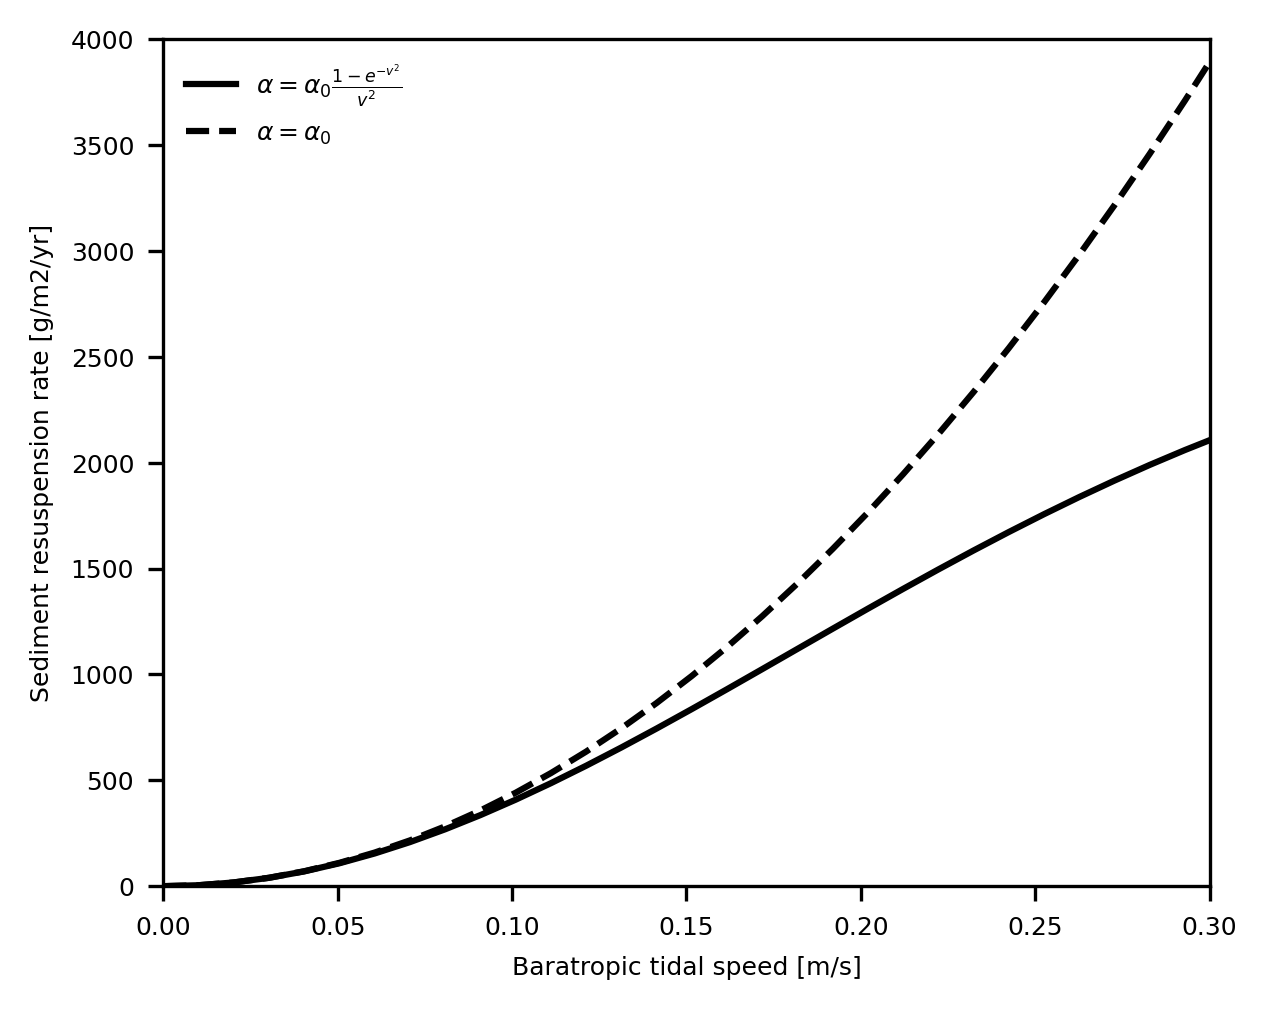

In [8]:
tide           = np.linspace(0,1,100)
changing_solubility_resus_rate = resus_cst*alpha_0_C*gamma*(1-np.exp(-(tide)**2/gamma))*3600*24*365*1e3
constant_solubility_resus_rate = resus_cst*alpha_0_C*(tide**2)*3600*24*365*1e3

fig, ax = plt.subplots(1,1, figsize=(4.5, 3.74), dpi=300)

ax.plot(tide, changing_solubility_resus_rate, '-k', label=r'$\alpha = \alpha_0\frac{1-e^{-v^2}}{v^2}$')
ax.plot(tide, constant_solubility_resus_rate, '--k', label=r'$\alpha = \alpha_0$')
ax.set_xlim([0, 0.3])
ax.set_ylim([0, 4e3])
ax.set_xlabel('Baratropic tidal speed [m/s]', fontsize=6)
ax.set_ylabel('Sediment resuspension rate [g/m2/yr]', fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)

ax.legend(fontsize=6, frameon=False)

## Plots

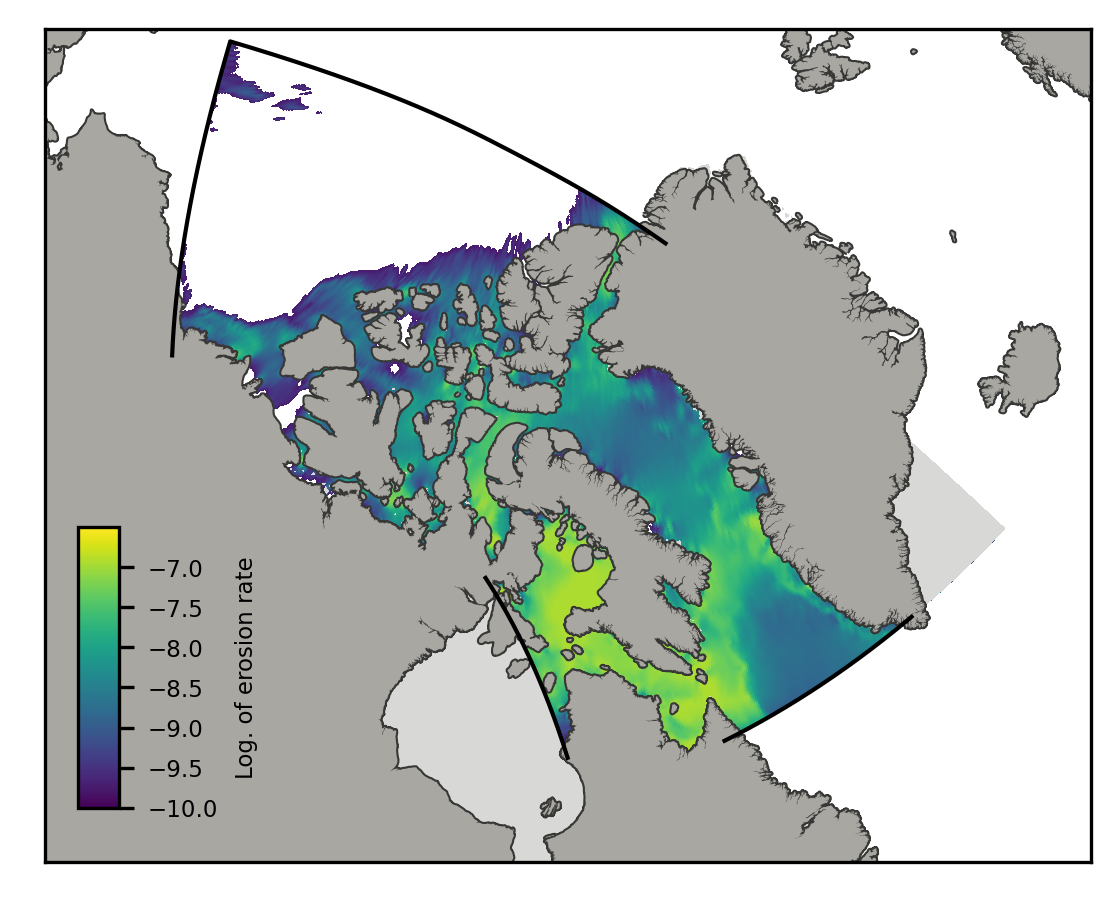

In [9]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/Pb-map.pickle','rb'))

# Sub-domain map: ---------------------------------------------------------------------------
x_sub, y_sub  = proj1(mesh_lon, mesh_lat) 

# tidal stress:
CB = proj1.pcolormesh(x_sub[imin:imax,jmin:jmax], y_sub[imin:imax,jmin:jmax], log_new_erosion_rate[imin:imax,jmin:jmax], \
                      vmin=-10, vmax=-6.5)

proj1.contourf(x_sub, y_sub, bathy_masked[0,:,:], colors=['#d8d8d6']) # land mask

# Domain boundaries: 
proj1.plot(x_sub[bdy_BB[0],bdy_BB[2]:bdy_BB[3]]   , y_sub[bdy_BB[0],bdy_BB[2]:bdy_BB[3]]   , '-k', lw=1, zorder=5); 
proj1.plot(x_sub[bdy_WCB[0],bdy_WCB[2]:bdy_WCB[3]], y_sub[bdy_WCB[0],bdy_WCB[2]:bdy_WCB[3]], '-k', lw=1, zorder=5); 
proj1.plot(x_sub[bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]], y_sub[bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]], '-k', lw=1, zorder=5);
proj1.plot(x_sub[bdy_HB[0]:bdy_HB[1],bdy_HB[2]]   , y_sub[bdy_HB[0]:bdy_HB[1],bdy_HB[2]]   , '-k', lw=1, zorder=5); 

cbaxes = fig.add_axes([0.15, 0.18, 0.03, 0.25])
CBar = plt.colorbar(CB, cax=cbaxes, ticks=np.arange(-10,-6.5,0.5))
CBar.ax.tick_params(labelsize=5.5)
CBar.set_label('Log. of erosion rate', fontsize=5.5)

In [13]:
file_write = xr.Dataset(
    {'er_rate': (("y","x"), new_erosion_rate)}, 
    coords = {
        "y": np.zeros(2400),
        "x": np.zeros(1632),
    },
    attrs = {
        'long_name':'Erosion rate',
        'units':'kg/m2/s',
    }
)

In [12]:
print('Units [g/m2/yr]')
print('Average erosion rate in domain: ', np.average(new_erosion_rate[imin:imax, jmin:jmax])*1000*365*24*3600)
print('Maximum erosion rate in domain: ', np.amax(new_erosion_rate[imin:imax, jmin:jmax])*1000*365*24*3600)
print('Minimum erosion rate in domain: ', np.amin(new_erosion_rate[imin:imax, jmin:jmax])*1000*365*24*3600)

print('Units [g/m2/yr]')
print('Average erosion rate in domain: ', np.average(old_erosion_rate[imin:imax, jmin:jmax])*1000*365*24*3600)
print('Maximum erosion rate in domain: ', np.amax(old_erosion_rate[imin:imax, jmin:jmax])*1000*365*24*3600)
print('Minimum erosion rate in domain: ', np.amin(old_erosion_rate[imin:imax, jmin:jmax])*1000*365*24*3600)

Units [g/m2/yr]
Average erosion rate in domain:  316.5213146449259
Maximum erosion rate in domain:  3746.476799245633
Minimum erosion rate in domain:  0.0
Units [g/m2/yr]
Average erosion rate in domain:  622.3847138698342
Maximum erosion rate in domain:  83643.68167750213
Minimum erosion rate in domain:  0.0


# Write to file:

In [ ]:
file_write = xr.Dataset(
    {'er_rate': (("y","x"), new_erosion_rate)}, 
    coords = {
        "y": np.zeros(2400),
        "x": np.zeros(1632),
    },
    attrs = {
        'long_name':'Erosion rate',
        'units':'kg/m2/s',
    }
)

In [14]:
file_write.to_netcdf('/ocean/brogalla/GEOTRACES/data/paper3-forcing-files/erosion_rate-Pb-20220322.nc')